All contracts are defined as in the CDC24 paper.

== Missing spec
InVars: []
OutVars:[J1, J2]
A: [
  
]
G: [
  3 J1 - 1.6 J2 <= -0.6
  -2.8 J1 + 1.23 J2 <= -0.3
]
== Missing spec by hand
InVars: []
OutVars:[J1, J2]
A: [
  
]
G: [
  -2.8 J1 + 1.23 J2 <= -0.3
  3 J1 - 1.6 J2 <= -0.6
]


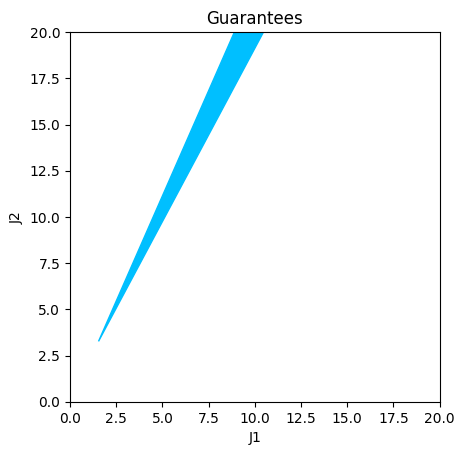

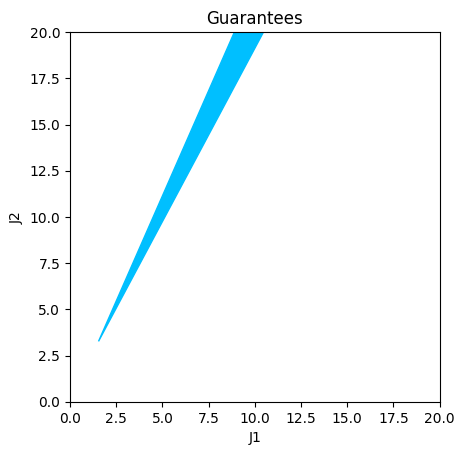

In [3]:
## constants
c = 1
delta = 1
# sigma 1
F_1_u_s = 5
F_1_u_h = 4
# sigma 2
p2_h = 0.6
p1_s = 1.1
p1_h = 0.3
F_2_p_1_s = 4.1
F_2_p_1_h = 4

# The following don't affect results
u_h = 10
u_s = 100


from pacti.contracts import PolyhedralIoContract
from pacti.utils import plots
from pacti.iocontract import Var
import numpy as np


top_level_objective = PolyhedralIoContract.from_strings(
    input_vars=["u"],
    output_vars=["p2"],
    assumptions=[f"{u_h}<= u <= {u_s}"],
    guarantees=[
    f"p2 >= {p2_h}"
    ]
    )


sigma1 = PolyhedralIoContract.from_strings(
    input_vars=["d1", "d2"],
    output_vars=["p1"],
    assumptions=[
    f"{(delta/c)*p1_h}*(1 + d1 + d2) <= d1",
    f"{(delta/c)*p1_s}*(1 + d1 + d2) >= d1",
    ],
    guarantees=[f"{p1_h} <= p1 <= {p1_s}"]
    )

sigma2 = PolyhedralIoContract.from_strings(
    input_vars=["d1", "d2", "p1"],
    output_vars=["p2"],
    assumptions=[
    f"{p1_h} <= p1 <= {p1_s}",
    f"{(delta/c)*p2_h}*(1 + d1 + d2) <= d2",
    ],
    guarantees=[f"{p2_h} <= p2"]
    )

resource_sharing = PolyhedralIoContract.from_strings(
    input_vars=["J1","J2","u"],
    output_vars=["d1","d2"],
    assumptions=[f"{u_h}<= u <= {u_s}"],
    guarantees=[
    f"{F_1_u_h} J1 <= d1 <= {F_1_u_s} J1",
    f"{F_2_p_1_h} J2 <= d2 <= {F_2_p_1_s} J2"
    ],
    )

by_hand = PolyhedralIoContract.from_strings(
    input_vars=[],
    output_vars=["J1","J2"],
    assumptions=[],
    guarantees=[
    f"{-F_1_u_h*(p1_s - 1)}*J1 - {p1_s*(F_2_p_1_h)} * J2 <= {p1_s}",
    f"{-F_1_u_h*(1 - p1_h)}*J1 + {p1_h*(F_2_p_1_s)} * J2 <= {-p1_h}",
    f"{F_1_u_s*(p2_h)}*J1 - {(1-p2_h)*(F_2_p_1_h)} * J2 <= {-p2_h}",
    ],
    )


system_spec = sigma1.compose(sigma2).compose(resource_sharing)

system_h_threshold = top_level_objective.quotient(system_spec)
print(f"== Missing spec\n{system_h_threshold}")
print(f"== Missing spec by hand\n{by_hand}")

_ = plots.plot_guarantees(contract=system_h_threshold,x_var=Var("J1"),y_var=Var("J2"),x_lims=(0,20),y_lims=(0,20),var_values={})
_ = plots.plot_guarantees(contract=system_h_threshold,x_var=Var("J1"),y_var=Var("J2"),x_lims=(0,20),y_lims=(0,20),var_values={})

[(0.499163169368085, 0.4886950238094487), (0.762666447988847, 0.23162544553971876), (0.8443548988508611, 0.15191085343923327), (0.8841924736231561, 0.11303237999058106), (0.9077888622396141, 0.09000300269007377)]
[[0.499163169368085, 0.762666447988847, 0.8443548988508611, 0.8841924736231561, 0.9077888622396141], [0.4886950238094487, 0.23162544553971876, 0.15191085343923327, 0.11303237999058106, 0.09000300269007377]]


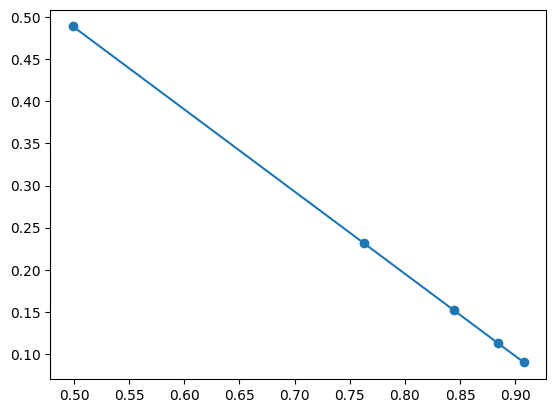

In [17]:
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline


def f1(x):
    return (F_1_u_s - F_1_u_h)/(u_s - u_h) * (x - u_h) + F_1_u_h

def f2(x):
    return (F_2_p_1_s - F_2_p_1_h)/(p1_s - p1_h) * (x - p1_h) + F_2_p_1_h

def F1(p1,theta1,theta2,u):
    return p1*(1 + theta1*f1(u) + theta2*f2(p1)) - theta1*f1(u)

def F2(p2,theta1,theta2,u,p1):
    return p2*(1 + theta1*f1(u) + theta2*f2(p1)) - theta2*f2(p1)

def getsol(theta1,theta2,u):
    a=fsolve(F1,1,args=(theta1,theta2,u))
    b=fsolve(F2,1,args=(theta1,theta2,u,a[0]))
    return a[0],b[0]
    

theta1 = 10
theta2 = 20

u_vals = np.linspace(u_h,u_s,5)
data = [getsol(u,theta1,theta2) for u in u_vals]
lists = list(map(list,zip(*data)))

print(data)
print(lists)

plt.plot(lists[0],lists[1],"-o")
plt.show()

Now we analyze constraints to guarantee the low thresholds

== Missing spec
InVars: []
OutVars:[J1, J2]
A: [
  
]
G: [
  0.06 J2 <= 0.4
  0.014 J1 <= 0.3
]


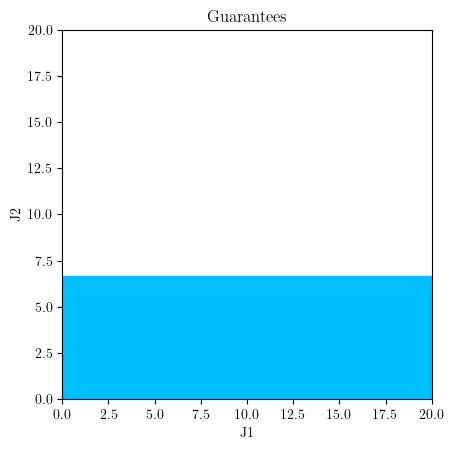

In [10]:
# sigma 1
F_1_u_m = 0
F_1_u_l = 0.02
# sigma 2
p2_l = 0.4
p1_l = 0.3
F_2_p_1_m = 0
F_2_p_1_l = 0.1

# The following don't affect results
u_l = 1
u_m = 0


top_level_objective_l = PolyhedralIoContract.from_strings(
    input_vars=["u"],
    output_vars=["p2"],
    assumptions=[f"{u_m}<= u <= {u_l}"],
    guarantees=[
    f"p2 <= {p2_l}"
    ]
    )


sigma1 = PolyhedralIoContract.from_strings(
    input_vars=["d1", "d2"],
    output_vars=["p1"],
    assumptions=[
    f"{(delta/c)*p1_l}*(1 + d1 + d2) >= d1",
    ],
    guarantees=[f"p1 <= {p1_l}"]
    )

sigma2 = PolyhedralIoContract.from_strings(
    input_vars=["d1", "d2", "p1"],
    output_vars=["p2"],
    assumptions=[
    f"p1 <= {p1_l}",
    f"{(delta/c)*p2_l}*(1 + d1 + d2) >= d2",
    ],
    guarantees=[f"{p2_l} >= p2"]
    )

resource_sharing = PolyhedralIoContract.from_strings(
    input_vars=["J1","J2","u"],
    output_vars=["d1","d2"],
    assumptions=[f"{u_m}<= u <= {u_l}"],
    guarantees=[
    f"{F_1_u_m} J1 <= d1 <= {F_1_u_l} J1",
    f"{F_2_p_1_m} J2 <= d2 <= {F_2_p_1_l} J2"
    ],
    )

system_spec_l = sigma1.compose(sigma2).compose(resource_sharing)
system_l_threshold = top_level_objective_l.quotient(system_spec_l)
print(f"== Missing spec\n{system_l_threshold}")

_ = plots.plot_guarantees(contract=system_l_threshold,x_var=Var("J1"),y_var=Var("J2"),x_lims=(0,20),y_lims=(0,20),var_values={})


The following plot shows the feasible region of the $J_i$ that will allow the circuit to meet its lower and upper thresholds.

== Overall spec
InVars: []
OutVars:[J1, J2]
A: [
  
]
G: [
  0.06 J2 <= 0.4
  3 J1 - 1.6 J2 <= -0.6
  -2.8 J1 + 1.23 J2 <= -0.3
]


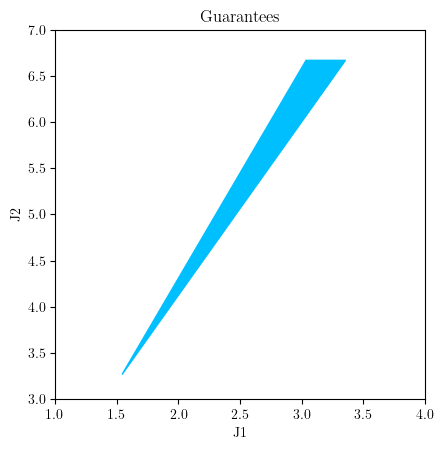

In [11]:
# We merge the upper and lower requirements to obtain J parameters that would ensure that the system meets both thresholds
overall_system = system_l_threshold.merge(system_h_threshold)
print(f"== Overall spec\n{overall_system}")
_ = plots.plot_guarantees(contract=overall_system,x_var=Var("J1"),y_var=Var("J2"),x_lims=(1,4),y_lims=(3,7),var_values={})

In [12]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

_.set_size_inches(w=2, h=3)
_.savefig('sequential.pgf',bbox_inches='tight')